In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import sklearn.decomposition as skde

from sklearn import feature_selection as fs

from sklearn import metrics

import sklearn.decomposition as skde

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

from sklearn import svm

%matplotlib inline

In [16]:
## Load dataset
AdvWorksCusts = pd.read_csv('./PreparedData/AdvWorksCusts_Prepared.csv')
AW_BikeBuyer = pd.read_csv('./PreparedData/AW_BikeBuyer_Prepared.csv')
AdvWorksCusts = AdvWorksCusts.merge(AW_BikeBuyer, on='CustomerID')
AdvWorksCusts.dtypes

CustomerID               int64
Title                   object
FirstName               object
MiddleName              object
LastName                object
Suffix                  object
AddressLine1            object
AddressLine2            object
City                    object
StateProvinceName       object
CountryRegionName       object
PostalCode              object
PhoneNumber             object
BirthDate               object
Education               object
Occupation              object
Gender                  object
MaritalStatus           object
HomeOwnerFlag            int64
NumberCarsOwned          int64
NumberChildrenAtHome     int64
TotalChildren            int64
YearlyIncome             int64
BikeBuyer                int64
dtype: object

In [17]:
# Examine the class imbalance in the data
AdvWorksCusts[['CustomerID', 'BikeBuyer']].groupby('BikeBuyer').count()

,CustomerID
BikeBuyer,
0,10953
1,5451


In [18]:
Features = np.array(pd.read_csv('./PreparedData/BikeBuyerFeatures.csv'))
Labels = np.array(pd.read_csv('./PreparedData/BikeBuyerLabels.csv'))
Features_test = np.array(pd.read_csv('./PreparedData/Features_test.csv'))
Features.shape

(16404, 34)

In [19]:
## Evaluation Helpers
def scoring_model(probs, threshold):
    # compute the positive (1) predictions
    return [1 if prob > threshold else 0 for prob in probs[:, 1]]

def print_metrics(labels, scores):
    conf = sklm.confusion_matrix(labels, scores)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    acc = sklm.accuracy_score(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0][0] + '             %5d' % conf[0][1])
    print('Actual negative    %6d' % conf[1][0] + '             %5d' % conf[1][1])
    print('')
    print('Accuracy  %0.2f' % acc)
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1]) 
    
def plot_auc(labels, probs):
    # Compute the false positive rate, true positive rate and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    # Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def print_cv(clf, params_grid, param = 'C'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())  
    # print(keys)
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter (AUC)')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))

        
## Nested cross validation
def nested_cross_val(estimator, param_grid, features, labels, n_splits, scoring='roc_auc'):
    inside = ms.KFold(n_splits=n_splits, shuffle=True)
    outside = ms.KFold(n_splits=n_splits, shuffle=True)
    
    estimator = ms.GridSearchCV(estimator=estimator, param_grid=param_grid,
                               cv=inside, scoring=scoring, return_train_score=True)
    estimator.fit(features, labels)
    
    cv_estimate = ms.cross_val_score(estimator=estimator, X=features, y=labels, cv=outside)
    
    print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
    print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
    print('Outcomes by cv fold')
    for i, x in enumerate(cv_estimate):
        print('Fold %2d    %4.3f' % (i+1, x))
        
    return estimator, estimator.best_estimator_  
 
    
## Split dataset
Features = np.array(pd.read_csv('./PreparedData/BikeBuyerFeatures.csv'))
Labels = np.array(pd.read_csv('./PreparedData/BikeBuyerLabels.csv'))

index = ms.train_test_split(range(Features.shape[0]), test_size=round(0.3*Features.shape[0]))
X_train = Features[index[0], :]
y_train = np.ravel(Labels[index[0]])
X_test = Features[index[1], :]
y_test = np.ravel(Labels[index[1]])

## Deal with Data Imbalance

In [20]:
y_train = y_train.reshape(y_train.shape[0],)
## Randomize the undersampling to create a data set with balanced cases
y_train_1 = y_train[y_train == 1] # save these
X_train_1 = X_train[y_train == 1, :]  # save these
y_train_0 = y_train[y_train == 0] # undersample these
X_train_0 = X_train[y_train == 0, :]  # undersmaple these
# Undersampling
index = nr.choice(X_train_0.shape[0], X_train_1.shape[0],
                 replace=True)
X_train = np.concatenate((X_train_1, X_train_0[index,:]),
                              axis=0)
y_train = np.concatenate((y_train_1, y_train_0[index,]), 
                            axis=0)
print(np.bincount(y_train), X_train.shape, y_train.shape)

[3800 3800] (7600, 34) (7600,)


In [21]:
Labels = Labels.reshape(Labels.shape[0],)
## Randomize the undersampling to create a data set with balanced cases
temp_Labels_1 = Labels[Labels == 1] # save these
temp_Features_1 = Features[Labels == 1, :]  # save these
temp_Labels_0 = Labels[Labels == 0] # undersample these
temp_Features_0 = Features[Labels == 0, :]  # undersmaple these
# Undersampling
index = nr.choice(temp_Features_0.shape[0], temp_Features_1.shape[0],
                 replace=True)
Features_balanced = np.concatenate((temp_Features_1, temp_Features_0[index,:]),
                              axis=0)
Labels_balanced = np.concatenate((temp_Labels_1, temp_Labels_0[index,]), 
                            axis=0)
print(np.bincount(Labels_balanced), Features_balanced.shape, Labels_balanced.shape)

[5451 5451] (10902, 34) (10902,)


## Feature Selection


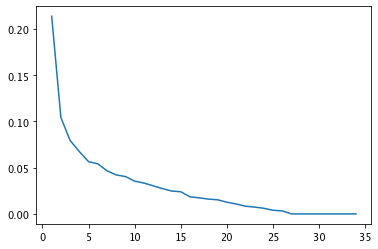

In [22]:
'''
# Remove features with low variance (variance threshold set to .8 * (1 - .8)))
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Feature_balanced_reduced = sel.fit_transform(Features_balanced)
Features_test_reduced = sel.fit_transform(Features_test)
# Reshape the Label array
Labels = Labels.reshape(Labels.shape[0],)
# Set folds for nested cross validation
feature_folds = ms.KFold(n_splits=10, shuffle = True) 
'''
## Use PCA
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(Features_balanced)
# Plot the importance curve for each feature
def plot_explained(mod):
    comps = mod.explained_variance_ratio_
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)

plot_explained(pca_comps)

In [23]:
# Trains and fits a PCA model with 20 selected components 
pca_mod = skde.PCA(n_components = 20).fit(Features_balanced)

X_train = pca_mod.transform(X_train)
X_test = pca_mod.transform(X_test)

Feature_balanced_reduced = pca_mod.transform(Features_balanced)
Features_test_reduced = pca_mod.transform(Features_test)

# Logistic Regression Model

In [24]:
## Build the model to predict and store the result
logistic_mod = linear_model.LogisticRegression(C=0.1, class_weight = {0:0.45, 1:0.55})
'''
# Perform feature selection by CV with high variance features only
selector = fs.RFECV(estimator = logistic_mod, cv = feature_folds,
                      scoring = 'roc_auc').fit(Features_reduced, Labels)
Features_logistic = selector.transform(Features_reduced)
Features_test_logistic = selector.transform(Features_test_reduced)
print(Features_logistic.shape, Features_test_logistic.shape)
'''
logistic_mod.fit(Feature_balanced_reduced, Labels_balanced)
probs = logistic_mod.predict_proba(Features_test_reduced)
result = scoring_model(probs, threshold=0.5)
pd.DataFrame(result).to_csv('./PredictionResults/BikeBuyerPrediction_LogisticRegression.csv', 
                            index = False, header = True)

# Random Forest Model

In [25]:
## Find better parameters by using nested cross validation
rf_clf = RandomForestClassifier()
param_grid = {'max_features': [2, 3, 5, 10, 15], 'min_samples_leaf':[3, 5, 10, 20]}
n_splits = 10
rf_clf, best_estimator_ = nested_cross_val(rf_clf, param_grid, Feature_balanced_reduced, Labels_balanced, n_splits)
print('best estimator:')
print(best_estimator_.max_features, best_estimator_.min_samples_leaf)

Mean performance metric = 0.855
SDT of the metric       = 0.008
Outcomes by cv fold
Fold  1    0.865
Fold  2    0.842
Fold  3    0.854
Fold  4    0.853
Fold  5    0.859
Fold  6    0.863
Fold  7    0.842
Fold  8    0.860
Fold  9    0.858
Fold 10    0.858
best estimator:
5 10


                 Confusion matrix
                 Score positive    Score negative
Actual positive      2349               921
Actual negative       373              1278

Accuracy  0.74
 
           Positive      Negative
Num case     3270          1651
Precision    0.86          0.58
Recall       0.72          0.77
F1           0.78          0.66


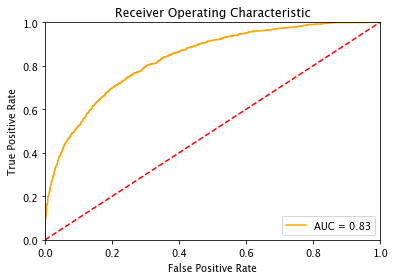

In [26]:
## Use the best parameters to test the performance
rf_mod = RandomForestClassifier(class_weight='balanced',
                               max_features=best_estimator_.max_features,
                               min_samples_leaf=best_estimator_.min_samples_leaf)
rf_mod.fit(X_train, y_train)
probs = rf_mod.predict_proba(X_test)
print_metrics(y_test, scoring_model(probs, 0.5))
plot_auc(y_test, probs)

In [27]:
## Build the model to predict and store the result
rf_mod = RandomForestClassifier(max_features = best_estimator_.max_features,
                                min_samples_leaf = best_estimator_.min_samples_leaf)
rf_mod.fit(Feature_balanced_reduced, Labels_balanced)
probs = rf_mod.predict_proba(Features_test_reduced)
result = scoring_model(probs, 0.5)
pd.DataFrame(result).to_csv('./PredictionResults/BikeBuyerPrediction_RandomForest.csv', 
                            index = False, header = True)

# AdaBoost Model

In [28]:
## Find better parameters by using nested cross validation
ab_clf = AdaBoostClassifier()
param_grid = {'learning_rate': [0.1, 1, 10]}
n_splits = 10
ab_clf, best_estimator_ = nested_cross_val(ab_clf, param_grid, Features, Labels, n_splits)
print('best estimator:')
print(best_estimator_.learning_rate)

Mean performance metric = 0.835
SDT of the metric       = 0.008
Outcomes by cv fold
Fold  1    0.839
Fold  2    0.840
Fold  3    0.822
Fold  4    0.846
Fold  5    0.830
Fold  6    0.836
Fold  7    0.827
Fold  8    0.840
Fold  9    0.843
Fold 10    0.823
best estimator:
1


                 Confusion matrix
                 Score positive    Score negative
Actual positive      2379               891
Actual negative       457              1194

Accuracy  0.73
 
           Positive      Negative
Num case     3270          1651
Precision    0.84          0.57
Recall       0.73          0.72
F1           0.78          0.64


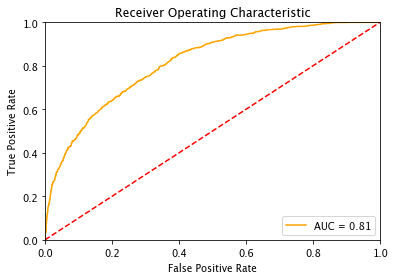

In [29]:
## Use the best parameters to test the performance
ab_mod = AdaBoostClassifier(learning_rate=best_estimator_.learning_rate)
ab_mod.fit(X_train, y_train)
probs = ab_mod.predict_proba(X_test)
print_metrics(y_test, scoring_model(probs, 0.5))
plot_auc(y_test, probs)

In [30]:
## Build the model to predict and store the result
ab_mod = AdaBoostClassifier(learning_rate=best_estimator_.learning_rate)
ab_mod.fit(Feature_balanced_reduced, Labels_balanced)
probs = rf_mod.predict_proba(Features_test_reduced)
result = scoring_model(probs, 0.5)
pd.DataFrame(result).to_csv('./PredictionResults/BikeBuyerPrediction_AdaBoost.csv', 
                            index = False, header = True)

# Neural Network

In [ ]:
## Build the model to predict and store the result
nn_mod = MLPClassifier(beta_1=0.9, beta_2=0.99)
nn_mod.fit(Feature_balanced_reduced, Labels_balanced)
probs = nn_mod.predict_proba(Features_test_reduced)
result = scoring_model(probs, 0.5)
pd.DataFrame(result).to_csv('./PredictionResults/BikeBuyerPrediction_NN.csv', 
                            index = False, header = True)

# SVM

In [ ]:
## Build the model to predict and store the result
svm_mod = svm.SVC(class_weight='balanced',
                 C=100,
                 gamma=0.02,
                 probability=True)
svm_mod.fit(Feature_balanced_reduced, Labels_balanced)
probs = svm_mod.predict_proba(Features_test_reduced)
result = scoring_model(probs, 0.5)
pd.DataFrame(result).to_csv('./PredictionResults/BikeBuyerPrediction_SVM.csv', 
                            index = False, header = True)